In [8]:
%run Common.ipynb

C:\Source\CSIRO\HealthyHabitat\.env
healthyhabitat
fKs+lhwiW7RsKCj/gL4veeTwTQq0othN/m0cBP8I7KFKJ+3ufdGFefXeuoayxeaKbd5wuGvi6MlMUf62TwiccA==
9d5465b8356d4e05868c63978bf5e45f


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry
from PIL import Image

In [3]:
%matplotlib inline

### Custom Vision - CSIRO Demo Project

In [4]:
ENDPOINT = 'https://australiaeast.api.cognitive.microsoft.com'

trainer = CustomVisionTrainingClient(custom_vision_training_key, endpoint=ENDPOINT)

projects = trainer.get_projects()

for project in projects:
    if project.name == 'CSIRODemo':
        project_id = project.id
        print('Project Id:', project_id)

Project Id: d85c4db7-fc07-46e7-917f-b4ed62311637


### List Containers

In [9]:
containers = blob_service_list_containers(account_name, storage_key)

for container_name in containers:
    print(container_name)

aaktest
bootdiagnostics-feraltrax-6485e715-a595-430f-9f45-47b9bef0b0a6
cannonhill-gurreng
cannonhill-wurrgeng
cannonhill-yegge
jabiru-dreaming-gurreng
jabiru-dreaming-yegge
middle-nardab-yegge
nestor-apn-2019
raw
raw-old
timelapse-jabirudreaming
ubir-latedry
ubir-latedry-tiles
ubir-yegge


### Create regions from images in each container

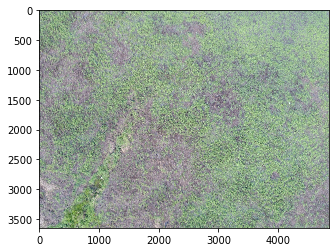

In [10]:
plt.imshow(image)
plt.show()

In [ ]:
y/n

In [7]:
images = []

for container_name in containers:
    if container_name == 'ubir-latedry':
        dst = '{0}-tiles'.format(container_name)
        
        blob_service_create_container(account_name, storage_key, dst)
        blobs = blob_service_list_blobs(account_name, storage_key, container_name)
        
        interim_folder_path = os.path.join(Path(os.getcwd()).parent, 'data', 'interim', container_name)
        
        os.makedirs(interim_folder_path)
        
        for blob_name in blobs:
            if not blob_name[0] == '.':
                file_path = os.path.join(interim_folder_path, blob_name)
                
                if not os.path.exists(file_path):
                    blob_service_get_blob_to_path(account_name, storage_key, container_name, blob_name, file_path)
                    
                    image = np.array(Image.open(file_path))
                    image_shape = image.shape
                
                    height = 456
                    width = 608

                    count = 0
                
                    for y in range(0, image_shape[0], height):
                        for x in range(0, image_shape[1], width):
                            region = image[y:y + height, x:x + width]
                        
                            file_name = '{0}_Region_{1}.jpg'.format(blob_name.split('.')[0], count)
                            file_path = os.path.join(interim_folder_path, file_name)

                            # Write to file system...
                            Image.fromarray(region).save(file_path)

                            # Write to Blob Storage...
                            byte_array = io.BytesIO()
                            Image.fromarray(region).save(byte_array, format='JPEG')

                            blob_service_create_blob_from_bytes(account_name, storage_key, dst, file_name, byte_array.getvalue())

                            # Custom Vision Project...
                            with open(file_path, mode="rb") as image_contents:
                                images.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read()))

                            count += 1
        
result = trainer.create_images_from_files(project_id, images=images)
        
if not result.is_batch_successful:
    print("Image batch upload failed.")
    for image in result.images:
        print("Image status: ", image.status)

WARNING - Retrying (Retry(total=2, connect=3, read=2, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', OSError("(10054, 'WSAECONNRESET')",))': /customvision/v3.0/training/projects/d85c4db7-fc07-46e7-917f-b4ed62311637/images/files
WARNING - Retrying (Retry(total=1, connect=3, read=1, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', OSError("(10054, 'WSAECONNRESET')",))': /customvision/v3.0/training/projects/d85c4db7-fc07-46e7-917f-b4ed62311637/images/files
WARNING - Retrying (Retry(total=0, connect=3, read=0, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', OSError("(10054, 'WSAECONNRESET')",))': /customvision/v3.0/training/projects/d85c4db7-fc07-46e7-917f-b4ed62311637/images/files


MemoryError: 